In [10]:
import sys
import time
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import select_model, Model
from graph_deep_decoder.architecture import Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering

# %matplotlib qt

DATASET_PATH = './dataset/SP500/SP500_GMRF_6sectors.npy'
# DATASET_PATH = './dataset/SP500/SP500_sm_6sectors.npy'
MAX_SIGNALS = 25
SEED = 0
PATH = './results/sp500/'

plt.rcParams['image.cmap'] = 'Spectral_r'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


- GCG benefits from data with unit norm. It also seems to work beter with 0 mena data.
- Normalized data seems more susceptible to noise

## Auxiliary functions

In [11]:
def get_best_err(err):
    mean_err = np.mean(err, axis=1)
    std = np.std(err, axis=1)
    best_epochs_mean = np.argmin(mean_err, axis=2)
    best_mean_err = np.zeros((len(N_P), len(Exps)))
    best_std = np.zeros((len(N_P), len(Exps)))
    for i in range(len(N_P)):
        for j in range(len(Exps)):
            best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
            best_std[i, j] = std[i, j, best_epochs_mean[i, j]]

    return best_mean_err, best_std, best_epochs_mean,


def plot_noise_err(err, legend, ylabel):
    fig = plt.figure()
    plt.semilogy(N_P, err, linewidth=4)
    plt.legend(legend, prop={'size': 12})
    plt.grid(True, which='both')
    plt.xlabel('Normalized noise power',fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlim([N_P[0], N_P[-1]])
    # plt.ylim([1e-3, 0.2])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    return fig


def print_err(err, std, weights):
    print('N_P:', N_P)
    for j, exp in enumerate(Exps):
        text = '{} ({}): '.format(exp['legend'], weights[j])
        for i, n_p in enumerate(N_P):
            text += '\t{:.4f} +- {:.4f}'.format(err[i, j], std[i, j]) 
        print(text)

def plot_iter_err(err, label):
    figs = []
    for i, n_p in enumerate(N_P):
        err_np = err[i]
        figs.append(plt.figure())
        plt.semilogy(err_np.T)
        plt.grid(True, which='both')
        plt.legend(legend)
        plt.title('{}: {}'.format(label, n_p))
        plt.xlim(left=0, right=err.shape[-1])
        plt.tight_layout()
        
    return figs

## Load dataset

Number of nodes: 189


Text(0.5, 1.0, 'Original graph')

<Figure size 432x288 with 0 Axes>

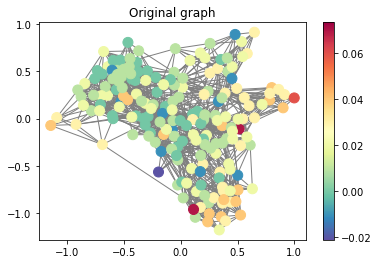

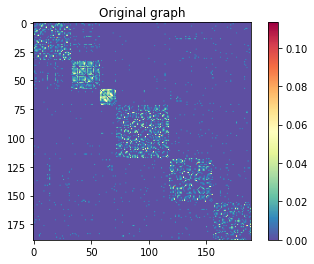

In [12]:
data = np.load(DATASET_PATH, allow_pickle=True).item()
X = data['X']
X_norm = (X - np.mean(X, axis=0))/np.std(X, axis=0)
n_signals = np.min([X.shape[1], MAX_SIGNALS])

A = data['A']
L = np.diag(np.sum(A, axis=0)) - A
S = A
print('Number of nodes:', A.shape[0])

G = Graph(A)
G.set_coordinates()
plt.figure()
G.plot_signal(X[:,0])
plt.title('Original graph')

plt.figure()
plt.imshow(A)
plt.colorbar()
plt.title('Original graph')



## Set the expetiments

<Figure size 432x288 with 0 Axes>

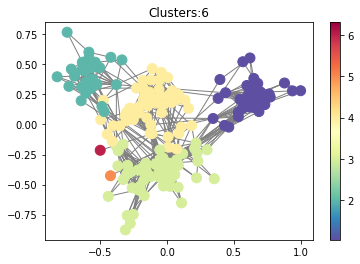

<Figure size 432x288 with 0 Axes>

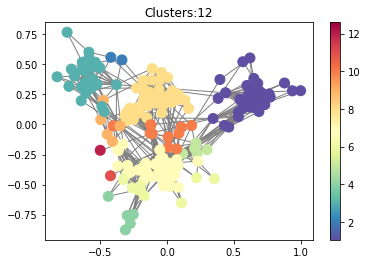

<Figure size 432x288 with 0 Axes>

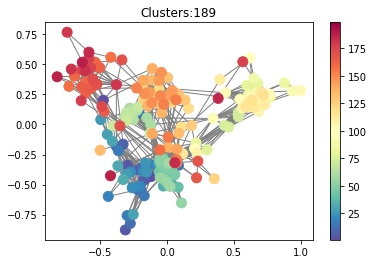

<Figure size 432x288 with 0 Axes>

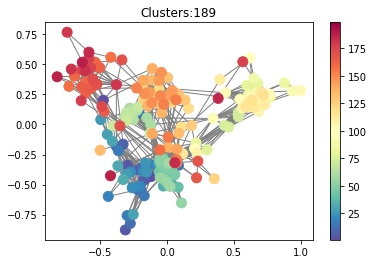

<Figure size 432x288 with 0 Axes>

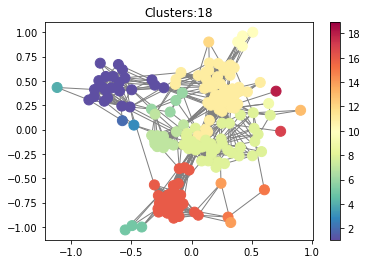

<Figure size 432x288 with 0 Axes>

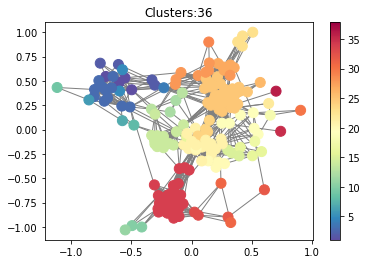

<Figure size 432x288 with 0 Axes>

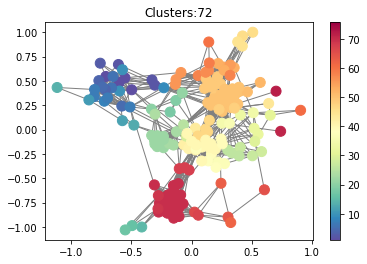

<Figure size 432x288 with 0 Axes>

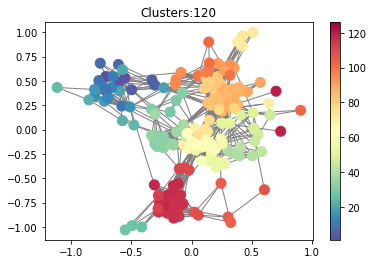

<Figure size 432x288 with 0 Axes>

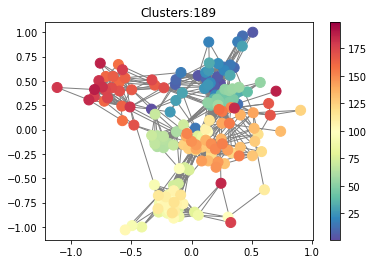

<Figure size 432x288 with 0 Axes>

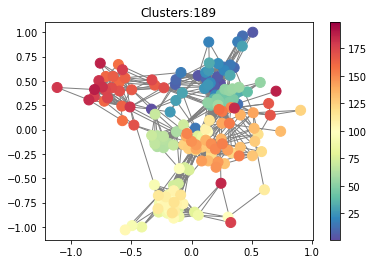

In [4]:
# USING GMRF graphs!

N_P = [0, .3]

# Model parameters
epochs =  500
lr = 0.001
loss = nn.MSELoss

Exps = [
        # CVX methods
        # {'type': 'BL', 'S': A, 'alpha': .05, 'legend': 'BL'},
        # {'type': 'TV', 'A': A, 'alpha': 5, 'legend': 'TV'},        
        # {'type': 'LR', 'L': L, 'alpha': 15, 'legend': 'LR'},
        # {'type': 'GTF', 'A': A, 'k': 3, 'lamb': .25, 'legend': 'GTF'},

        # Non-convex
        # {'type': 'MED', 'S': A, 'legend': 'MED'},
        {'type': 'GCNN', 'fts': 50, 'A': A, 'last_fts': 1, 'last_act': None,
         'loss': loss(reduction='none'), 'legend': 'GCNN'},
        {'type': 'GAT', 'fts': 50, 'A': A, 'heads': 3, 'last_fts': 1, 'last_act': None,
         'loss': loss(reduction='none'), 'legend': 'GAT'},
        # {'type': 'KronAE', 'fts': 50, 'A': A, 'r': .5, 'last_act': nn.Sigmoid(),
        #  'loss': loss(reduction='none'), 'legend': 'K-GAE'},

        # GCG - features - conv
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [15]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [30]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [45]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [60]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},


        # GCG - features - BL
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [15]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [30]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [45]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [60]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        
        # GD - features - 2 ups
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [6, 12] + [G.N]*2, 'fts': [15]*3 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [6, 12] + [G.N]*2, 'fts': [30]*3 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [6, 12] + [G.N]*2, 'fts': [45]*3 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [6, 12] + [G.N]*2, 'fts': [60]*3 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [6, 12] + [G.N]*2, 'fts': [75]*3 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},
         
         
        # GD - features - More ups
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [18, 36, 72, 120] + [G.N]*2, 'fts': [15]*5 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [18, 36, 72, 120] + [G.N]*2, 'fts': [30]*5 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [18, 36, 72, 120] + [G.N]*2, 'fts': [45]*5 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [18, 36, 72, 120] + [G.N]*2, 'fts': [60]*5 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [18, 36, 72, 120] + [G.N]*2, 'fts': [75]*5 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5, 
         'loss': loss(reduction='none'), 'legend': 'GD'},



        # With bn
        # {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [1],
        #  'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': 1, 'bn': True,
        #  'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
        #  'loss': loss(reduction='none'), 'legend': 'GCG'},
        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [1],
        #  'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .5, 'bn': True, 'gamma': 0, 
        #  'loss': loss(reduction='none'), 'legend': 'GD'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

# Compute needed matrices
for exp in Exps:
    if exp['type'] == 'DD' and exp['legend'] == 'GD':
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='ward')
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As

        # clt.plot_labels()
    elif exp['type'] == 'DD' and exp['legend'] == 'GCG':
        H = utils.create_filter(S, exp['h_params'])
        exp['Us'] =[H]*(len(exp['nodes'])-2) + [None]
        exp['As'] = []


In [5]:
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        # x = X_norm[:, j]

        x = X[:, j]
        x /= np.linalg.norm(x)
        
        x_n = ds.GraphSignal.add_noise(x, n_p, n_type='gaussian')
    
        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                _, err[i, j, k], _ = model.fit(x_n, x, device=device)
                
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)

            err[i, j, k] = err[i, j, k]/np.linalg.norm(x,2)**2

        # print('{} ({},{}): err rate: {:.3f} '.format(exp['legend'], l ,j, err[i, idx, k].min()))
        print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
Noise: 0.3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

--- 10.342139891783397 minutes ---


### Plot results

N_P: [0, 0.3]
GCNN (2701.0): 	0.0070 +- 0.0019	0.2759 +- 0.0533
GAT (8501.0): 	0.2929 +- 0.1263	0.3669 +- 0.0821
GCG (7260.0): 	0.0000 +- 0.0000	0.2667 +- 0.0400
GD (1830.0): 	0.5619 +- 0.1685	0.5812 +- 0.1721
GD (3630.0): 	0.4019 +- 0.1173	0.4626 +- 0.1243

N_P: [0, 0.3]
GCNN (2701.0): 	0.0070 +- 0.0019	0.2857 +- 0.0292
GAT (8501.0): 	0.2929 +- 0.1263	0.3669 +- 0.0821
GCG (7260.0): 	0.0000 +- 0.0000	0.2974 +- 0.0285
GD (1830.0): 	0.5619 +- 0.1685	0.5815 +- 0.1721
GD (3630.0): 	0.4022 +- 0.1176	0.4639 +- 0.1241


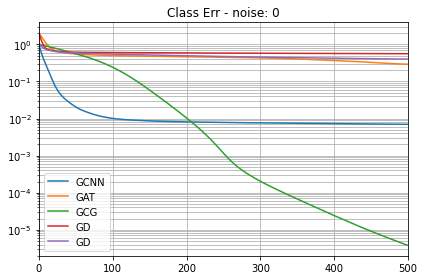

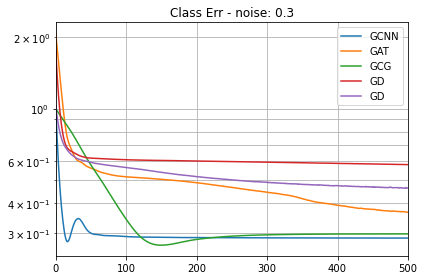

In [6]:
best_mean_err, std, _ = get_best_err(err)
fixed_mean_err = np.mean(err, axis=1)[:, :, -1]
fixed_std = np.std(err, axis=1)[:, :, -1]

print_err(best_mean_err, std, weights)
print()
print_err(fixed_mean_err, fixed_std, weights)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')

In [8]:
# # Save data
# data = {
#     'seed': SEED,
#     'N_P': N_P,
#     'exps': Exps,
#     'err': err,
#     'lr': lr,
#     'weights': weights,
#     'legend': legend,
#     'fmts': [],
# }
# utils.save_results('cora_baselines', PATH, data)

In [9]:
plt.show()